In [1]:
# Load the TensorBoard notebook extension
# In colab this can be done prior to the pip install above.
# I added the pip install since it was done in the dev summit 2019 video
%load_ext tensorboard.notebook

In [2]:
# google collab 

#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
print(tf.__version__)

2.0.0-alpha0


In [5]:
#from google.colab import files
#uploaded = files.upload()

In [6]:
# google collab version
#CSV_FILE_NAME = "usgs_gsvb_v2.csv"
# jupyter notebook version
CSV_FILE_NAME = "../csv/usgs_gsvb_v2.csv"
os.environ['CSV_FILE_NAME'] = CSV_FILE_NAME

In [7]:
LOG_DIR_NAME = "logs"
os.environ['LOG_DIR_NAME'] = LOG_DIR_NAME

In [8]:
%%bash
echo ${LOG_DIR_NAME}

logs


In [9]:
%%bash
# clear any logs from previous runs
rm -rf ./${LOG_DIR_NAME}

In [10]:
%%bash
head ${CSV_FILE_NAME}

usgs,site_no,date,tidal_high,tidal_low,precipitation_inches,lat,long
GSVB,33670001,2019-03-08,-6.7913385826771648,-6.7257217847769031,,36.735303,-76.011602
GSVB,33670001,2019-03-19,-6.8569553805774275,-6.758530183727034,,36.735303,-76.011602
GSVB,33670001,2019-02-21,1.9356955380577427,2.1325459317585302,,36.735303,-76.011602
GSVB,33670001,2019-03-11,-6.66010498687664,-6.4304461942257216,,36.735303,-76.011602
GSVB,33670001,2019-04-04,1.9028871391076114,2.0669291338582676,,36.735303,-76.011602
GSVB,33670001,2019-02-14,1.7716535433070866,1.9356955380577427,,36.735303,-76.011602
GSVB,33670001,2019-04-14,2.2309711286089238,2.39501312335958,,36.735303,-76.011602
GSVB,33670001,2019-02-24,2.65748031496063,2.9527559055118111,,36.735303,-76.011602
GSVB,33670001,2019-01-12,2.2965879265091864,2.39501312335958,,36.735303,-76.011602


In [11]:
%%bash
# this csv file has 9875 lines corresponding to records (plus one header row)
wc -l ${CSV_FILE_NAME}

    9876 ../csv/usgs_gsvb_v2.csv


# Use generic python to read data into pandas dataframe

## In order to add default values for missing data, use the converters helper functions

In [12]:
# Create a function to look for nans in the dataframe
# call via nans(dataset)
nans = lambda df: df[df.isnull().any(axis=1)]

In [13]:
# Anytime there is missing data for high tide column, use the default value of 1.2
def default_tidal_high(cell_value):
    # print(type(cell_value))
    # print("value is {}".format(cell_value))
    
    # Input cell values are strings
    # The blanks for missing values are litteral blanks
    try:
        ret_value = float(cell_value)
        return ret_value
    except:
        # Average of available data
        return float(1.2)
        
    return cell_value       

In [14]:
def default_tidal_low(cell_value):
    # print(type(cell_value))
    # print("value is {}".format(cell_value))
    
    # Input cell values are strings
    # The blanks for missing values are litteral blanks
    try:
        ret_value = float(cell_value)
        return ret_value
    except:
        # Average of available data
        return float(-0.89)
        
    return cell_value       

In [15]:
def default_precipitation(cell_value):
    # print(type(cell_value))
    # print("value is {}".format(cell_value))
    
    # Input cell values are strings
    # The blanks for missing values are litteral blanks
    try:
        ret_value = float(cell_value)
        return ret_value
    except:
        # the average rainfall divided by 365.
        return float(0.117)
        
    return cell_value       

In [16]:
raw_dataset = pd.read_csv(CSV_FILE_NAME, 
                          header=0,
                          parse_dates=[2],
                          converters={'precipitation_inches':default_precipitation, 
                                      'tidal_high':default_tidal_high,
                                      'tidal_low': default_tidal_low},
                          sep=",")

dataset = raw_dataset.copy()

In [17]:
# This should show an empty set
nans(dataset)

,usgs,site_no,date,tidal_high,tidal_low,precipitation_inches,lat,long


In [18]:
# The head shows how blank precipitation_inches default is present
dataset.head()

,usgs,site_no,date,tidal_high,tidal_low,precipitation_inches,lat,long
0,GSVB,33670001,2019-03-08,-6.791339,-6.725722,0.117,36.735303,-76.011602
1,GSVB,33670001,2019-03-19,-6.856955,-6.758530,0.117,36.735303,-76.011602
2,GSVB,33670001,2019-02-21,1.935696,2.132546,0.117,36.735303,-76.011602
3,GSVB,33670001,2019-03-11,-6.660105,-6.430446,0.117,36.735303,-76.011602
4,GSVB,33670001,2019-04-04,1.902887,2.066929,0.117,36.735303,-76.011602


In [19]:
# The tail shows how a true precipitation values from csv is present
dataset.tail()

,usgs,site_no,date,tidal_high,tidal_low,precipitation_inches,lat,long
9870,USGS,204291317,2017-12-23,0.70,-1.53,0.06,36.843306,-76.124472
9871,USGS,204291317,2016-05-05,3.58,-0.26,0.06,36.843306,-76.124472
9872,USGS,204291317,2019-01-12,1.07,-0.88,0.06,36.843306,-76.124472
9873,USGS,204291317,2019-01-08,1.60,-0.85,0.06,36.843306,-76.124472
9874,USGS,204291317,2017-04-26,2.38,-0.88,0.06,36.843306,-76.124472


# Are the columns the correct datatypes?

In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9875 entries, 0 to 9874
Data columns (total 8 columns):
usgs                    9875 non-null object
site_no                 9875 non-null int64
date                    9875 non-null datetime64[ns]
tidal_high              9875 non-null float64
tidal_low               9875 non-null float64
precipitation_inches    9875 non-null float64
lat                     9875 non-null float64
long                    9875 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 617.3+ KB


In [21]:
# this only returns numeric columns.  'date' column is ommited
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
site_no,9875.0,1.595645e+08,8.112594e+07,2.042928e+06,2.042885e+08,2.042913e+08,2.042955e+08,2.043003e+08
tidal_high,9875.0,1.208827e+00,1.668611e+00,-2.132546e+01,7.800000e-01,1.410000e+00,1.964252e+00,7.020000e+00
tidal_low,9875.0,-8.881704e-01,1.350213e+00,-1.407480e+01,-1.490000e+00,-8.900000e-01,-3.400000e-01,1.013780e+01
precipitation_inches,9875.0,1.316892e-01,4.401681e-01,-2.670000e+00,0.000000e+00,1.170000e-01,1.170000e-01,9.490000e+00
lat,9875.0,3.679307e+01,6.597209e-02,3.658199e+01,3.671169e+01,3.682478e+01,3.684114e+01,3.690352e+01
long,9875.0,-7.607719e+01,9.532894e-02,-7.629074e+01,-7.612447e+01,-7.606092e+01,-7.598525e+01,-7.592638e+01


# Split the data into train, test and validation datasets

In [22]:
train_ds = dataset.sample(frac=0.7,random_state=3367)

In [23]:
leftover_ds = dataset.drop(train_ds.index)

In [24]:
test_ds = leftover_ds.sample(frac=0.5, random_state=3367)

In [25]:
valid_ds = leftover_ds.drop(test_ds.index)

### examine the split datasets

In [26]:
print("train size = {}".format(train_ds.shape))
print("test size = {}".format(test_ds.shape))
print("valid size = {}".format(valid_ds.shape))
print("sum of rows = {}".format(train_ds.shape[0] + test_ds.shape[0] + valid_ds.shape[0]))

train size = (6912, 8)
test size = (1482, 8)
valid size = (1481, 8)
sum of rows = 9875


In [27]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6912 entries, 2053 to 8942
Data columns (total 8 columns):
usgs                    6912 non-null object
site_no                 6912 non-null int64
date                    6912 non-null datetime64[ns]
tidal_high              6912 non-null float64
tidal_low               6912 non-null float64
precipitation_inches    6912 non-null float64
lat                     6912 non-null float64
long                    6912 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 486.0+ KB


# Inspect the data
Have a quick look at the joint distribution of few pairs of columns from training set

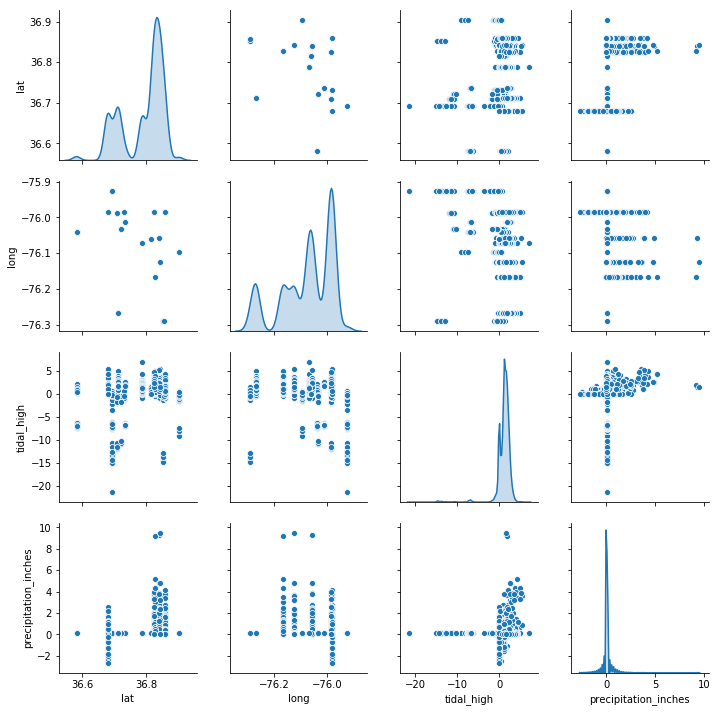

In [28]:
# Omit the date
sns.pairplot(train_ds[["lat", "long", "tidal_high", "precipitation_inches"]], diag_kind="kde")

In [29]:
train_ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
site_no,6912.0,1.591171e+08,8.153117e+07,2.042928e+06,2.042885e+08,2.042913e+08,2.042955e+08,2.043003e+08
tidal_high,6912.0,1.199061e+00,1.687287e+00,-2.132546e+01,7.600000e-01,1.400000e+00,1.962126e+00,7.020000e+00
tidal_low,6912.0,-9.001521e-01,1.349539e+00,-1.407480e+01,-1.490000e+00,-8.900000e-01,-3.600000e-01,6.725722e+00
precipitation_inches,6912.0,1.311445e-01,4.546988e-01,-2.670000e+00,0.000000e+00,1.170000e-01,1.170000e-01,9.490000e+00
lat,6912.0,3.679232e+01,6.561202e-02,3.658199e+01,3.671169e+01,3.682478e+01,3.684114e+01,3.690352e+01
long,6912.0,-7.607650e+01,9.573631e-02,-7.629074e+01,-7.612447e+01,-7.605714e+01,-7.598525e+01,-7.592638e+01


# Split features from labels

In [30]:
# Create seperate series/dataframe? for labels
# Remove the label from the dataframes.
train_labels = train_ds.pop('tidal_high')
test_labels = test_ds.pop('tidal_high')
valid_labels = valid_ds.pop('tidal_high')
#
# Also remove the columns which are not used as features
train_ds.drop(['usgs','tidal_low','site_no'], axis=1, inplace=True)
test_ds.drop(['usgs','tidal_low','site_no'], axis=1, inplace=True)
valid_ds.drop(['usgs','tidal_low','site_no'], axis=1, inplace=True)

In [31]:
train_ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
precipitation_inches,6912.0,0.131145,0.454699,-2.67000,0.000000,0.117000,0.117000,9.49000
lat,6912.0,36.792325,0.065612,36.58199,36.711694,36.824778,36.841139,36.90352
long,6912.0,-76.076501,0.095736,-76.29074,-76.124472,-76.057139,-75.985250,-75.92638


In [32]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6912 entries, 2053 to 8942
Data columns (total 4 columns):
date                    6912 non-null datetime64[ns]
precipitation_inches    6912 non-null float64
lat                     6912 non-null float64
long                    6912 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 590.0 KB


# Normalize the data

In [33]:
# Use the training data to get mean and std.  Use it
# to normalize the datasets.  This will not have 
# the date column.
train_stats = train_ds.describe().transpose()

def norm(a_df):
    # Since data used to normalize data is only for numeric columns,
    # the data column is not present.  Remove this column, do the normalize
    # operation and then join back the date column
    
    # create a date dataframe from one column. 
    # Use the list selector for a single column to make it a df instead of a series
    the_dates_df = a_df[['date']]
    # remove the date column since its saved now.
    a_df.pop('date')
    # Do the norm operation
    normed_df = (a_df - train_stats['mean']) / train_stats['std']
    # add back the date column to normalized dataframe
    normed_df = the_dates_df.join(normed_df)
    return normed_df

normed_train_ds = norm(train_ds)
normed_test_ds = norm(test_ds)
normed_valid_ds = norm(valid_ds)

In [34]:
normed_train_ds.head()

,date,precipitation_inches,lat,long
2053,2017-10-19,-0.838235,-1.714918,0.966206
539,2019-03-09,-0.031107,-1.262646,0.920246
2445,2017-04-05,1.383015,-1.714918,0.966206
5486,2018-07-30,-0.031107,0.357450,0.162784
7349,2018-12-30,-0.288421,0.494620,0.953149


# model can not handle dates.  Remove for now.

In [35]:
normed_train_ds.drop(['date'], axis=1, inplace=True)
normed_test_ds.drop(['date'], axis=1, inplace=True)
normed_valid_ds.drop(['date'], axis=1, inplace=True)

# The model

## Build the model using keras and sequential

In [36]:
# train_ds determines the input feature size
model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_ds.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
    ])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])


## Inspect the model

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [38]:
normed_train_ds.keys()

Index(['precipitation_inches', 'lat', 'long'], dtype='object')

Try out the model.  Take a batch of 10 samples from training data and call `model_predict` on it.

In [39]:
example_batch = normed_train_ds[:10]
example_batch.head()

,precipitation_inches,lat,long
2053,-0.838235,-1.714918,0.966206
539,-0.031107,-1.262646,0.920246
2445,1.383015,-1.714918,0.966206
5486,-0.031107,0.357450,0.162784
7349,-0.288421,0.494620,0.953149


In [40]:
example_result = model.predict(example_batch)
example_result

array([[-0.40077108],
       [-0.30998588],
       [-0.38441843],
       [-0.06424193],
       [-0.24009736],
       [-0.07442114],
       [-0.47878796],
       [-0.24009736],
       [-0.06424193],
       [-0.17555092]], dtype=float32)

# Train the model
Train the model for 1000 epochs and record the training and validation accuracy in the history object.

In [63]:
%%bash
# clear any logs from previous runs
rm -rf ./${LOG_DIR_NAME}

In [48]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 1333), started -1 day, 23:03:38 ago. (Use '!kill 1333' to kill it.)

In [64]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [65]:
EPOCHS = 1000

logdir = os.path.join(LOG_DIR_NAME, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
print(logdir)

logs/20190505-144629


I can either train this model using a tensorflow callback or the print doc callback.  If I put in a list, 
it does not seem to call both.

## Tensorboard callback version

In [52]:
history = model.fit(normed_train_ds, 
                    train_labels,
                    epochs=EPOCHS, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[tensorboard_callback])

In [53]:

# clear any tensorboards if they are running
# this will kill the processes for Tensorboard
!ps aux | grep tensorboard | awk '{print $2}' | xargs kill

kill: 1359: No such process


## PrintDot callback version

In [66]:
# The author is printing dots rather than the regular output. Interesting.
# Also, the author is saving the result of model.fit and then loads the history portion
# into a dataframe later
history = model.fit(normed_train_ds, 
                    train_labels,
                    epochs=EPOCHS, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the models training progress using the stats sotred in the `history` object

In [67]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,1.843055,0.717731,1.843055,1.289347,0.669901,1.289347,995
996,1.826387,0.721598,1.826388,1.487040,0.687512,1.487040,996
997,1.840406,0.720844,1.840407,1.283835,0.654547,1.283835,997
998,1.843202,0.722774,1.843201,1.263364,0.637662,1.263364,998
999,1.805932,0.718521,1.805933,1.429235,0.661890,1.429235,999


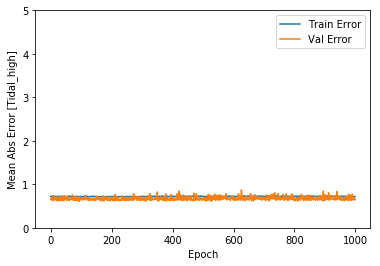

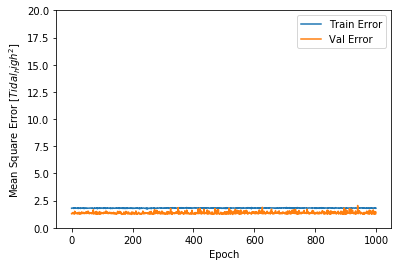

In [68]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Tidal_high]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Tidal_high^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)